In [1]:
import pandas as pd
# Display all rows and columns in output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# Load the CSV data from the correct path
file_path = r'D:\Development\BatteryEQOptimizer\flood_acid_battery_data.csv'
battery_data = pd.read_csv(file_path)

# Load the temperature correction factors from the CSV file
correction_file_path = r"D:\Development\BatteryEQOptimizer\sg_correction_factor.csv"
correction_factors = pd.read_csv(correction_file_path)

# Convert 'date' to datetime format in the battery data
battery_data['date'] = pd.to_datetime(battery_data['date'], format='%m/%d/%Y')

# Ensure all specific gravity columns (1-16) are numeric and convert any non-numeric values to NaN
for col in battery_data.columns[1:17]:  # Adjust if necessary
    battery_data[col] = pd.to_numeric(battery_data[col], errors='coerce')

# Function to apply temperature correction
def apply_temperature_correction(battery_data, correction_factors):
    corrected_data = battery_data.copy()
    
    for i, row in corrected_data.iterrows():
        temp = row['temp_battery']
        closest_factor = correction_factors.loc[(correction_factors['electrolyte_temp_F'] - temp).abs().idxmin(), 'sg_correction_factor']
        
        # Apply correction to the specific gravity readings for each battery (assuming batteries are in columns 1-16)
        for col in corrected_data.columns[1:17]:  # Adjust if your battery columns are different
            corrected_data.loc[i, col] += closest_factor
    
    return corrected_data

# Apply temperature correction
corrected_battery_data = apply_temperature_correction(battery_data, correction_factors)

# Function to calculate statistics (mean and greatest difference) for each battery by date
def battery_statistics(data):
    stats = []
    battery_columns = data.columns[1:17]  # Battery columns (adjust if needed)
    
    for date, group in data.groupby('date'):
        for battery in battery_columns:
            # Calculate mean state of charge for the battery
            mean_soc = round(group[battery].mean(), 4)
            
            # Calculate the greatest difference between cell values for the battery
            max_diff = round(group[battery].max() - group[battery].min(), 4)
            
            stats.append({
                'Date': date,
                'Battery': battery,
                'Mean SOC': mean_soc,
                'Greatest Difference': max_diff
            })
    
    return pd.DataFrame(stats)

# Get statistics for each battery by date
battery_stats = battery_statistics(corrected_battery_data)

# Display the calculated statistics
print(battery_stats)

# Optionally save the results to a CSV file
battery_stats.to_csv(r'D:\Development\BatteryEQOptimizer\battery_statistics_with_corrections.csv', index=False)


         Date Battery  Mean SOC  Greatest Difference
0  2024-09-27      B1    1.2583                0.017
1  2024-09-27      B2    1.2377                0.005
2  2024-09-27      B3    1.2417                0.009
3  2024-09-27      B4    1.2403                0.030
4  2024-09-27      B5    1.1783                0.020
5  2024-09-27      B6    1.2443                0.015
6  2024-09-27      B7    1.2370                0.005
7  2024-09-27      B8    1.2457                0.020
8  2024-09-27      B9    1.2397                0.020
9  2024-09-27     B10    1.2377                0.023
10 2024-09-27     B11    1.2333                0.015
11 2024-09-27     B12    1.2350                0.010
12 2024-09-27     B13    1.2380                0.014
13 2024-09-27     B14    1.2333                0.015
14 2024-09-27     B15    1.2230                0.020
15 2024-09-27     B16    1.2390                0.023
16 2024-10-12      B1    1.2697                0.014
17 2024-10-12      B2    1.2603               

In [2]:
# Ensure that the 'sg_correction_factor' column is numeric
correction_factors['sg_correction_factor'] = pd.to_numeric(correction_factors['sg_correction_factor'], errors='coerce')

# Ensure all specific gravity columns (1-16) are numeric and convert any non-numeric values to NaN
for col in battery_data.columns[1:17]:  # Adjust if necessary
    battery_data[col] = pd.to_numeric(battery_data[col], errors='coerce')

# Function to apply temperature correction
def apply_temperature_correction(battery_data, correction_factors):
    corrected_data = battery_data.copy()
    
    for i, row in corrected_data.iterrows():
        temp = row['temp_battery']
        # Find the closest temperature correction factor from the table
        closest_factor = correction_factors.loc[(correction_factors['electrolyte_temp_F'] - temp).abs().idxmin(), 'sg_correction_factor']
        
        # Apply correction to the specific gravity readings for each battery (assuming batteries are in columns 1-16)
        for col in corrected_data.columns[1:17]:  # Adjust this range if your battery columns are different
            if pd.notna(corrected_data.loc[i, col]):  # Apply correction only if value is numeric
                corrected_data.loc[i, col] += closest_factor
    
    return corrected_data

# Apply the correction to the battery data
corrected_battery_data = apply_temperature_correction(battery_data, correction_factors)

# Function to calculate summary statistics for the entire battery bank by date
def bank_summary_statistics(data):
    bank_summary_stats = []
    
    for date, group in data.groupby('date'):
        # Calculate the average Specific Gravity for the entire battery bank
        avg_specific_gravity_bank = round(group.iloc[:, 1:17].mean().mean(), 3)  # Mean of all batteries
        
        # Calculate the greatest difference between all cells in the entire battery bank
        greatest_diff_bank = round((group.iloc[:, 1:17].max().max() - group.iloc[:, 1:17].min().min()), 3)
        
        # Calculate the greatest difference among the averages of the battery cells
        battery_means = group.iloc[:, 1:17].mean()  # Averages of each battery's cells
        greatest_diff_among_means = round(battery_means.max() - battery_means.min(), 3)
        
        bank_summary_stats.append({
            'Date': date,
            'Average Specific Gravity (Bank)': avg_specific_gravity_bank,
            'Greatest Difference (Bank)': greatest_diff_bank,
            'Greatest Difference Among Averages': greatest_diff_among_means
        })
    
    return pd.DataFrame(bank_summary_stats)

# Get the bank summary statistics for each date
bank_summary_stats = bank_summary_statistics(corrected_battery_data)

# Display the bank summary statistics
print(bank_summary_stats)

# Save the bank summary statistics to a CSV file
bank_summary_stats.to_csv(r'D:\Development\BatteryEQOptimizer\bank_summary_statistics_with_averages.csv', index=False)

        Date  Average Specific Gravity (Bank)  Greatest Difference (Bank)  \
0 2024-09-27                            1.235                       0.100   
1 2024-10-12                            1.259                       0.034   
2 2024-10-16                            1.262                       0.038   
3 2024-11-18                            1.266                       0.034   

   Greatest Difference Among Averages  
0                               0.080  
1                               0.020  
2                               0.023  
3                               0.020  


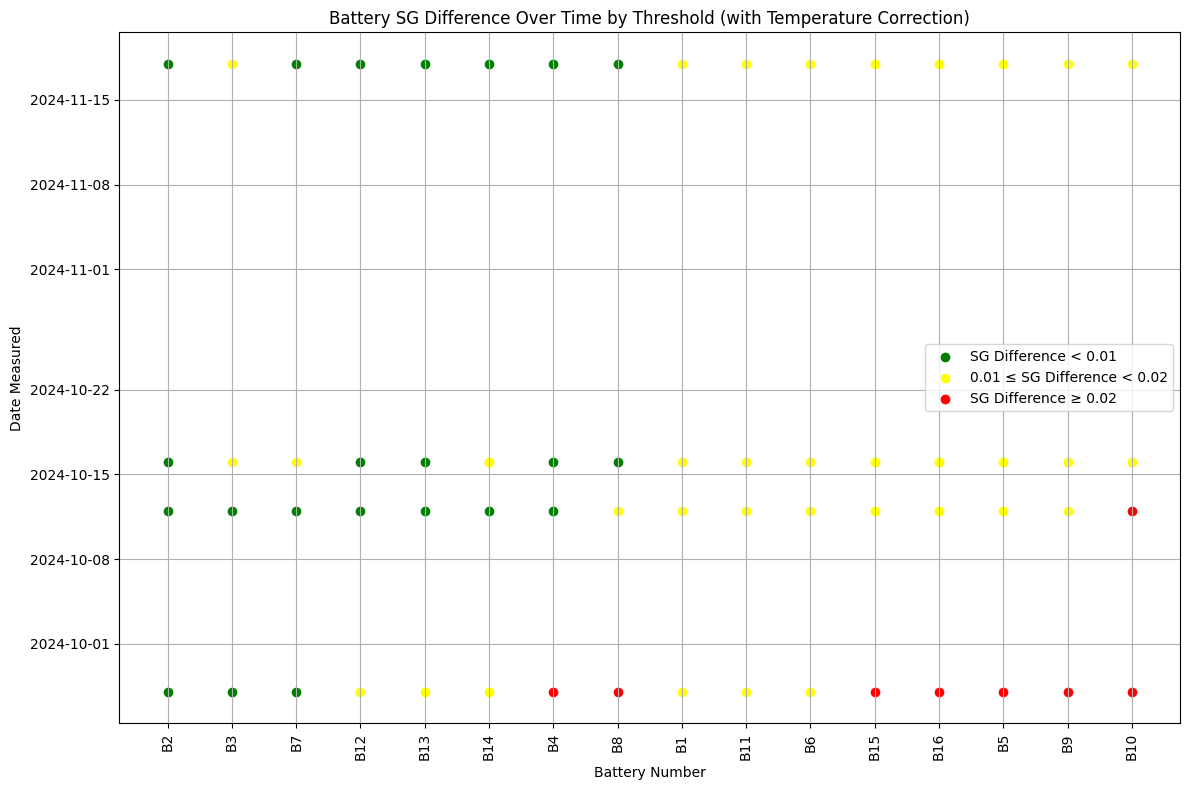

In [3]:
import matplotlib.pyplot as plt

# Ensure all specific gravity columns (B-Q) are numeric and convert any non-numeric values to NaN
for col in battery_data.columns[1:17]:  # Adjust if necessary
    battery_data[col] = pd.to_numeric(battery_data[col], errors='coerce')

# Function to apply temperature correction
def apply_temperature_correction(battery_data, correction_factors):
    corrected_data = battery_data.copy()
    
    for i, row in corrected_data.iterrows():
        temp = row['temp_battery']
        closest_factor = correction_factors.loc[(correction_factors['electrolyte_temp_F'] - temp).abs().idxmin(), 'sg_correction_factor']
        
        # Apply correction to each battery's SG values (B through Q)
        for col in corrected_data.columns[1:17]:  # Adjust range if necessary
            if pd.notna(corrected_data.loc[i, col]):  # Apply correction only if value is numeric
                corrected_data.loc[i, col] += closest_factor
    
    return corrected_data

# Apply temperature correction
corrected_battery_data = apply_temperature_correction(battery_data, correction_factors)

# Convert corrected data to long format for each battery column (B-Q or however they're named)
battery_columns = corrected_battery_data.columns[1:17]  # Update based on specific SG columns
battery_data_long = corrected_battery_data.melt(id_vars=['date'], value_vars=battery_columns, 
                                                var_name='Battery', value_name='SG')

# Drop any rows with missing specific gravity values
battery_data_long.dropna(subset=['SG'], inplace=True)

# Calculate the maximum difference in SG readings across cells within each battery and date
battery_diff = battery_data_long.groupby(['date', 'Battery'])['SG'].agg(['max', 'min'])
battery_diff['Max_Diff'] = battery_diff['max'] - battery_diff['min']
battery_diff = battery_diff.reset_index()

# Set color based on the difference threshold
battery_diff['Color'] = 'green'  # Default color
battery_diff.loc[(battery_diff['Max_Diff'] >= 0.01) & (battery_diff['Max_Diff'] < 0.02), 'Color'] = 'yellow'
battery_diff.loc[battery_diff['Max_Diff'] >= 0.02, 'Color'] = 'red'

# Plotting
plt.figure(figsize=(12, 8))

# Plot each threshold category separately for better control over legend
plt.scatter(battery_diff[battery_diff['Color'] == 'green']['Battery'], 
            battery_diff[battery_diff['Color'] == 'green']['date'], 
            color='green', label='SG Difference < 0.01')
plt.scatter(battery_diff[battery_diff['Color'] == 'yellow']['Battery'], 
            battery_diff[battery_diff['Color'] == 'yellow']['date'], 
            color='yellow', label='0.01 ≤ SG Difference < 0.02')
plt.scatter(battery_diff[battery_diff['Color'] == 'red']['Battery'], 
            battery_diff[battery_diff['Color'] == 'red']['date'], 
            color='red', label='SG Difference ≥ 0.02')

# Customize plot
plt.xlabel('Battery Number')
plt.ylabel('Date Measured')
plt.title('Battery SG Difference Over Time by Threshold (with Temperature Correction)')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
